Python Version: 2.7
    
Description: Portfolio Allocation in stocks using Mean-Variance.
Mean-variance analysis is the process of weighing risk, expressed as variance, against expected return. Investors use mean-variance analysis to make decisions about which financial instruments to invest in, based on how much risk they are willing to take on in exchange for different levels of reward.

Import Packages and set Quandl API Key. You can get this key by creating an Quandl Account.

In [21]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import quandl
quandl.ApiConfig.api_key = "Dypz-FGFn7umZ1vbpy5B"

Download Stock Data.

We will be downloading data for Apple, Ford, Tesla, Microsoft and Amazon.

After downloading the data, we will loop through them and store them in stock_prices dataframe

In [22]:
stocks = ['AAPL','F','TSLA','MSFT','AMZN']
          
stock_prices = pd.DataFrame()

for stock in stocks:
    new_stock = quandl.get('WIKI/'+stock,
    start_date="2012-01-01")['Adj. Close']
    stock_prices[stock] = new_stock
    
stock_prices.head(5)

,AAPL,F,TSLA,MSFT,AMZN
Date,,,,,
2012-01-03,52.848787,8.772734,28.08,22.792249,179.03
2012-01-04,53.132802,8.906729,27.71,23.332995,177.51
2012-01-05,53.722681,9.135309,27.12,23.571435,177.61
2012-01-06,54.284287,9.229893,26.91,23.933352,182.61
2012-01-09,54.198183,9.300832,27.25,23.622529,178.56


Separate the data into train and test set. The test set will be used to compute the equity curve for the weights generated.

In [23]:
train = stock_prices[stock_prices.index < '2017-01-01']
test = stock_prices[stock_prices.index >= '2017-01-01']

We have downloaded prices, but the Mean-Variance technique require Returns in percentage form. Lets convert the prices to percentage form. 

Formula for Returns: (Todays Return = Todays Price - Yesterdays Price) / Yesterdays Price

As the first day will not contain any returns, we will remove it.

In [24]:
returns = train.pct_change()
returns = returns.iloc[1:] 
returns = returns + 1
returns.head(5)

,AAPL,F,TSLA,MSFT,AMZN
Date,,,,,
2012-01-04,1.005374,1.015274,0.986823,1.023725,0.991510
2012-01-05,1.011102,1.025664,0.978708,1.010219,1.000563
2012-01-06,1.010454,1.010354,0.992257,1.015354,1.028152
2012-01-09,0.998414,1.007686,1.012635,0.987013,0.977822
2012-01-10,1.003580,1.000000,1.013578,1.003605,1.004368


Initialize Parameters:
    
We want the sum of all weights to be 1 and all the weights to be positive. 

We are aiming for 12% yearly return

In [25]:
# Mean return for each stock (in array)
r = np.array(np.mean(returns, axis=0))

# Covariance matrix between stocks (in array)
S = np.array(returns.cov())

# Vector of 1's equal in length to r
e = np.ones(len(r))

# Set the projected mean return for the portfolio
mu = 1+(0.12/252) # 12% rate annually per day

Initializing random initial weights for the portfolios

In [26]:
def objective(w):
    return np.matmul(np.matmul(w,S),w)

# Set initial weight values
w = np.random.random(len(r))

In [27]:
# Define Constraints
const = ({'type' : 'ineq' , 'fun' : lambda w: np.dot(w,r) - mu}, # returns - mu >= 0
         {'type' : 'eq' , 'fun' : lambda w: np.dot(w,e) - 1})    # sum(w) - 1 = 0

# Create Bounds
# Creates a tuple of tuples to pass to minimize
# to ensure all weights are betwen [0, 1]
non_neg = []
for i in range(len(r)):
    non_neg.append((0,1))
non_neg = tuple(non_neg)

The next block of code will run the Linear Solver. The weights are stored in solution.x
Not necessary all the stocks will get weights. 

In [28]:
# Run optimization with SLSQP solver
solution = minimize(fun=objective, x0=w, method='SLSQP',constraints=const,bounds=non_neg)
w = solution.x.round(6)
print w
print w.sum()
print list(returns.columns[w > 0.0])

[0.211937 0.168888 0.065491 0.442036 0.111648]
0.9999999999999999
['AAPL', 'F', 'TSLA', 'MSFT', 'AMZN']


In [29]:
# Invest $100,000 on Jan. 1st 2017
num_shares = w * 100000 / test.iloc[0,]
np.dot(num_shares, test.iloc[0,])
portfolio_equity = test.dot(num_shares)

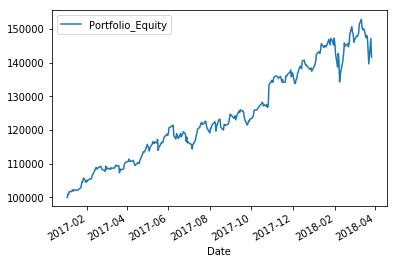

In [30]:
portfolio = pd.DataFrame({'Portfolio_Equity' : portfolio_equity})
%matplotlib inline
portfolio.plot(kind='line')